In [1]:
#import sys
#!{sys.executable} -m pip install optuna

In [31]:
# Importazione delle librerie necessarie
# plotting e calcolo scientifico
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

#machin learning

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import xgboost as xgb

from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

import optuna

In [32]:
df = pd.read_csv('titanic_data.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


          Not Survived  Survived
Embarked                        
C                44.64     55.36
Q                61.04     38.96
S                66.25     33.75
Total            61.71     38.29
Pclass        1      2      3
Embarked                     
C         50.60  10.12  39.29
Q          2.60   3.90  93.51
S         19.60  25.51  54.90
Total     23.99  20.72  55.29


<Axes: xlabel='Embarked'>

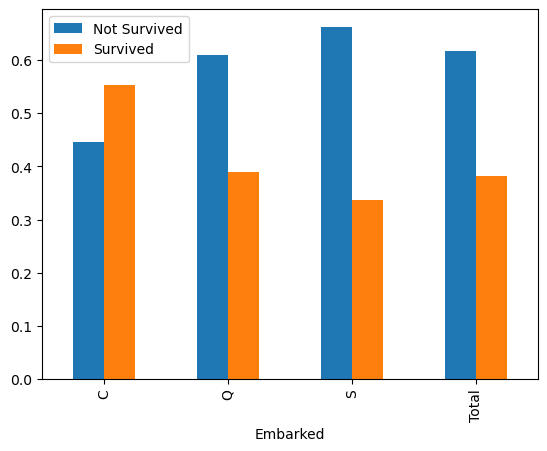

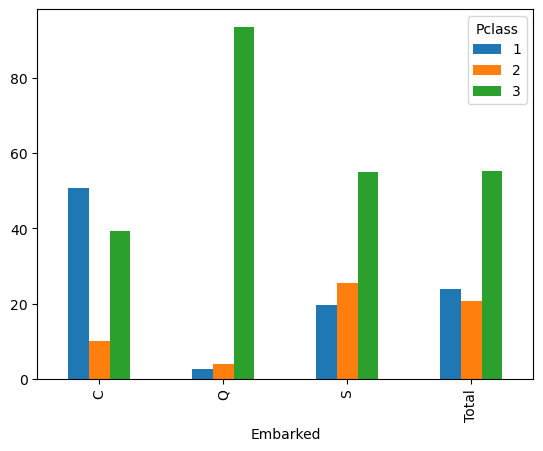

In [77]:
# Crosstab normalizzato per riga
ct = pd.crosstab(
    index=df['Embarked'],
    columns=df['Survived'],
    normalize='index',     # normalizza per riga
    margins=True,          # aggiunge i totali
    margins_name='Total'   # nome della colonna/indice dei totali
)

# Rinomina le colonne per chiarezza
ct.columns = ['Not Survived', 'Survived']

# Mostra con valori in percentuale
ct_percent = (ct * 100).round(2)

print(ct_percent)

ct_Emb_class = pd.crosstab(
    index=df['Embarked'],
    columns=df['Pclass'],
    normalize='index',     # normalizza per riga
    margins=True,          # aggiunge i totali
    margins_name='Total'   # nome della colonna/indice dei totali
)

# Mostra con valori in percentuale
ct_Emb_class = (ct_Emb_class * 100).round(2)

print(ct_Emb_class)

ct.plot.bar()
ct_Emb_class.plot.bar()

In [6]:
pd.crosstab(index=df['Ticket'], columns='counts')

col_0,counts
Ticket,
110152,3
110413,3
110465,2
110564,1
110813,1
...,...
W./C. 6608,4
W./C. 6609,1
W.E.P. 5734,1


In [80]:
null_fraction = (
    df.isnull()
            .mean()
            .rename("fraction_nulls")
            .to_frame()
)

print(null_fraction)

             fraction_nulls
PassengerId        0.000000
Survived           0.000000
Pclass             0.000000
Name               0.000000
Sex                0.000000
Age                0.000000
SibSp              0.000000
Parch              0.000000
Ticket             0.000000
Fare               0.000000
Cabin              0.771910
Embarked           0.002247
Deck               0.000000


In [81]:
df['Age'] = df['Age'].fillna(df.groupby(['Sex', 'Pclass'])['Age'].transform('median'))
df['Deck'] = df['Cabin'].astype(str).str.upper().str[0]
df = df[df['Deck'] != 'T']
pd.crosstab(index = df['Deck'], columns='counts')
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode())



**analysys of fair**

(array([496., 191.,  45.,  45.,  48.,  13.,  11.,  11.,   9.,   2.,   0.,
          0.,   5.,   4.,   2.,   6.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.]),
 array([  0.     ,  17.07764,  34.15528,  51.23292,  68.31056,  85.3882 ,
        102.46584, 119.54348, 136.62112, 153.69876, 170.7764 , 187.85404,
        204.93168, 222.00932, 239.08696, 256.1646 , 273.24224, 290.31988,
        307.39752, 324.47516, 341.5528 , 358.63044, 375.70808, 392.78572,
        409.86336, 426.941  , 444.01864, 461.09628, 478.17392, 495.25156,
        512.3292 ]),
 <BarContainer object of 30 artists>)

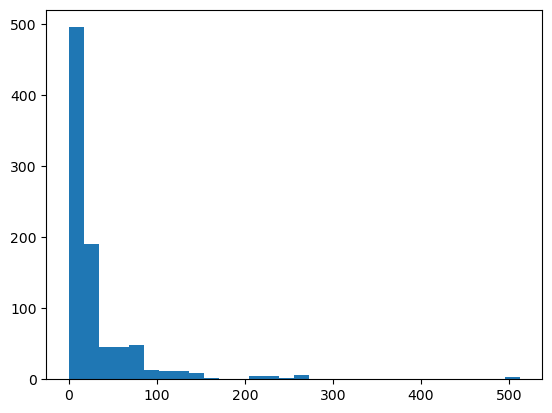

In [34]:
plt.hist(df['Fare'], bins = 30)

In [9]:
df["prize_range"] = pd.cut(df['Fare'], bins = [0, 90, 200, 400, 700], labels = ['normal', 'high', 'extreme', "crazly expensive"])

In [10]:
survived_class = pd.crosstab(index = df["prize_range"], columns = df['Survived'], margins = True)  # Crosstab
survived_class.columns = ["Not Survived", "Survived", "Total row"]
survived_class.index = ['normal', 'high', 'extreme', "crazly expensive", "Total Col"]
survived_class

,Not Survived,Survived,Total row
normal,521,298,819
high,8,29,37
extreme,6,11,17
crazly expensive,0,3,3
Total Col,535,341,876


**Selezione colonne di interesse e creazione X,y**

In [98]:
col_to_use = ['Pclass','Sex','Age', 'SibSp', 'Parch', 'Fare', 'Deck']
X= df[col_to_use]
y = df['Survived']

In [12]:
df[col_to_use].describe()

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


In [99]:
#normalizzazione
col_to_normalize = ['Age', 'SibSp', 'Parch', 'Fare']  #non c'è Pclasss provare a metterla dopo

scaler = StandardScaler()

X[col_to_normalize] = scaler.fit_transform(X[col_to_normalize])

#X.loc[:, 'Pclass'] = X['Pclass'].astype('object')

# now we are good to go with out cleaned data. Now we are going to make dummy variables for our whole dataset.
X = pd.get_dummies(X, drop_first=True) # it is a short cut to avoid dummy variable trap it is just dropping the main column whose dummies we have produced. 

C:\Users\m-rog\AppData\Local\Temp\ipykernel_11340\975735087.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col_to_normalize] = scaler.fit_transform(X[col_to_normalize])


In [91]:
X

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_N,Embarked_Q,Embarked_S
0,3,-0.533677,0.432072,-0.473999,-0.502090,True,False,False,False,False,False,False,True,False,True
1,1,0.669896,0.432072,-0.473999,0.786480,False,False,True,False,False,False,False,False,False,False
2,3,-0.232784,-0.474872,-0.473999,-0.488507,False,False,False,False,False,False,False,True,False,True
3,1,0.444226,0.432072,-0.473999,0.420570,False,False,True,False,False,False,False,False,False,True
4,3,0.444226,-0.474872,-0.473999,-0.485991,True,False,False,False,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,-0.157561,-0.474872,-0.473999,-0.386380,True,False,False,False,False,False,False,True,False,True
887,1,-0.759347,-0.474872,-0.473999,-0.044282,False,True,False,False,False,False,False,False,False,True
888,3,-0.571289,0.432072,2.007527,-0.176090,False,False,False,False,False,False,False,True,False,True
889,1,-0.232784,-0.474872,-0.473999,-0.044282,True,False,True,False,False,False,False,False,False,False


**test/train split**

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

**XGBClassifier**

In [101]:
def objective_raw(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'objective': 'binary:logistic',
        'n_jobs': -1,
        'random_state': 42,
        'verbosity': 0
    }
    
    model = xgb.XGBClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    
    return scores.mean()


In [102]:
study_raw = optuna.create_study(direction='maximize')
study_raw.optimize(objective_raw, n_trials=30, show_progress_bar=True)

print(f"\nBest CV Accuracy (Raw): {study_raw.best_value:.4f}")

# ------------------------------------------------------------------------------
# 5. CONFRONTO FINALE
# ------------------------------------------------------------------------------
# Training modello Raw finale
best_params_raw = study_raw.best_params
model = xgb.XGBClassifier(**best_params_raw )

model.fit(X_train, y_train)
y_pred_raw = model.predict(X_test)

[I 2025-12-05 13:14:17,113] A new study created in memory with name: no-name-6c117816-ac3e-4968-b196-2b403be5b2bc


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-05 13:14:17,179] Trial 0 finished with value: 0.8146853146853147 and parameters: {'n_estimators': 383, 'learning_rate': 0.3767103824197704, 'max_depth': 4, 'subsample': 0.7098833558060947, 'colsample_bytree': 0.851793639861681, 'gamma': 3.0480772164296095, 'reg_alpha': 2.2645700275482638e-07, 'reg_lambda': 3.669219126550912e-06}. Best is trial 0 with value: 0.8146853146853147.
[I 2025-12-05 13:14:17,258] Trial 1 finished with value: 0.8132374667585935 and parameters: {'n_estimators': 302, 'learning_rate': 0.012252564618455815, 'max_depth': 5, 'subsample': 0.9455865489954227, 'colsample_bytree': 0.8572021988956191, 'gamma': 0.4133629241376502, 'reg_alpha': 2.080801266148751e-06, 'reg_lambda': 0.0074114556474893945}. Best is trial 0 with value: 0.8146853146853147.
[I 2025-12-05 13:14:17,337] Trial 2 finished with value: 0.7978233034571063 and parameters: {'n_estimators': 552, 'learning_rate': 0.3653921289380602, 'max_depth': 10, 'subsample': 0.8288023696020517, 'colsample_bytr

In [103]:
# --- 5. Risultati ---
print("\n--- Tuning Completato ---")
print(f"Migliori Parametri Trovati: {best_params_raw}")


target_names = ['survived', 'not survived']

print("\n--- Report Finale (Test Set) ---")
print(f"Accuratezza Reale: {accuracy_score(y_test, y_pred_raw):.4f}")
print(classification_report(y_test, y_pred_raw, target_names=target_names))


--- Tuning Completato ---
Migliori Parametri Trovati: {'n_estimators': 178, 'learning_rate': 0.1505521341889274, 'max_depth': 9, 'subsample': 0.9258265085912246, 'colsample_bytree': 0.808189726981591, 'gamma': 2.109649702673711, 'reg_alpha': 5.010187835360094e-07, 'reg_lambda': 1.6357469798584604e-06}

--- Report Finale (Test Set) ---
Accuratezza Reale: 0.8483
              precision    recall  f1-score   support

    survived       0.84      0.89      0.87        98
not survived       0.85      0.80      0.83        80

    accuracy                           0.85       178
   macro avg       0.85      0.84      0.85       178
weighted avg       0.85      0.85      0.85       178



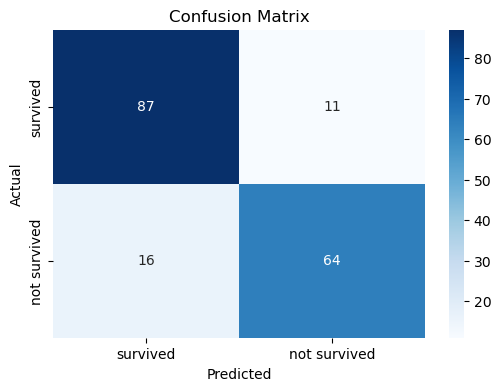

In [104]:

# 6. Visualizza la matrice di confusione

cm = confusion_matrix(y_test, y_pred_raw)


# Visualizzazione della matrice di confusione

plt.figure(figsize=(6,4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',

            xticklabels = target_names,

            yticklabels = target_names)

plt.xlabel('Predicted')

plt.ylabel('Actual')

plt.title('Confusion Matrix')

plt.show()

**Logistic regression**

In [105]:
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# C valori più realistici
C = np.logspace(-1, 3, 10)   # da 0.1 a 1000

model = LogisticRegressionCV(Cs=C, cv=5, max_iter=5000)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8707865168539326

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89        98
           1       0.89      0.81      0.85        80

    accuracy                           0.87       178
   macro avg       0.87      0.87      0.87       178
weighted avg       0.87      0.87      0.87       178


Confusion Matrix:
 [[90  8]
 [15 65]]


da risultati molto simili a xgboost, leggermente peggiori

**feature engenereing**

In [30]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,prize_range
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,normal
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,normal
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,normal
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,normal
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,normal
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,normal
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,normal
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,normal
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,normal
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,normal
